# ML Regression Method Comparison - time series
Datasets:
    - https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
    - file name : "day.csv" or "hour.csv"
Methods:
    - Linear Regression [Polynomial, etc...]
    - Linear Regression with basis funtions
    - Conditional Random Fields
    - Neural Net
    - LTSM
    - KDE

# Read Me stuff from data
Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

Remove holiday, random forest - reduce dimensionality bsed

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import random as rand
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
# Data ingest
df = pd.read_csv('hour.csv')
print(df.shape)
print(df.head(5))

(17379, 17)
   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


# Preprocessing/ EDA

In [8]:
# Seperate indices from data from labels
index, data, count_casual,count_registered, count = df['instant'] , df.iloc[1:-2], df['casual'], df['registered'], df['cnt']
data.info()
# Here we split the categorical data from the numerical
cat_data = data[['season','yr','mnth','hr','holiday','weekday','workingday','weathersit']]
num_data = data[['temp','atemp','hum','windspeed']]
print("Are There Missing Data? :",data.isnull().any().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17376 entries, 1 to 17376
Data columns (total 17 columns):
instant       17376 non-null int64
dteday        17376 non-null object
season        17376 non-null int64
yr            17376 non-null int64
mnth          17376 non-null int64
hr            17376 non-null int64
holiday       17376 non-null int64
weekday       17376 non-null int64
workingday    17376 non-null int64
weathersit    17376 non-null int64
temp          17376 non-null float64
atemp         17376 non-null float64
hum           17376 non-null float64
windspeed     17376 non-null float64
casual        17376 non-null int64
registered    17376 non-null int64
cnt           17376 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
Are There Missing Data? : False


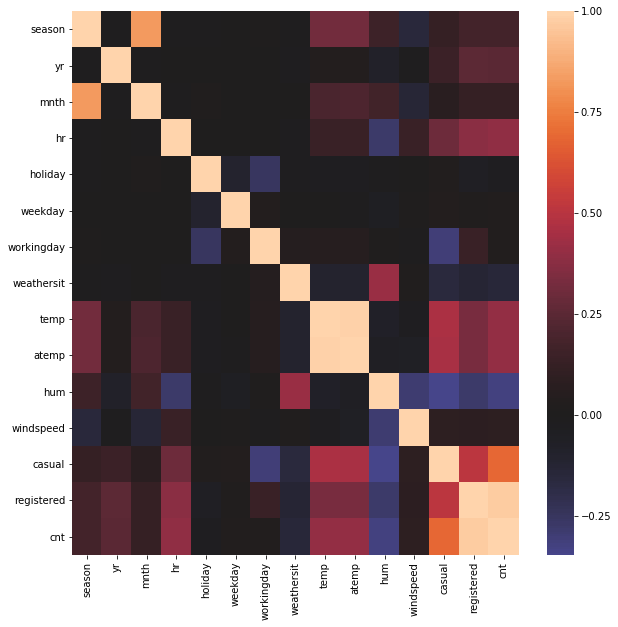

In [10]:
# Look at numerical data regression
corr = df.iloc[:,1:].corr()

plt.figure(figsize = (10,10))
sns.heatmap(corr, center = 0 )

In [13]:
# This is the one-hot encoding for categorical data
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(cat_data)
enc.transform(cat_data)
'''
# Apply transform to fix date issue
import datetime
def fix_date(date):
    d = date.strip().split('-')
    dt = datetime.datetime(int(d[0]),int(d[1]),int(d[2]))
    # Note I ignore timezones and the like and just let python default to whatever as it is a simple linear shift.
    return dt.timestamp()
data['dteday'] = data['dteday'].apply(fix_date)
print(data.head())
'''
print(cat_data.head())

   season  yr  mnth  hr  holiday  weekday  workingday  weathersit
1       1   0     1   1        0        6           0           1
2       1   0     1   2        0        6           0           1
3       1   0     1   3        0        6           0           1
4       1   0     1   4        0        6           0           1
5       1   0     1   5        0        6           0           2


# Numerical Regression

# Linear Regression
Methods
    - Least Squares (L2)
    - Lasso (L1)
    - Ridge

In [7]:
from sklearn import model_selection
from sklearn import linear_model

In [42]:
# Least Squares
def linear_reg(x_train, x_test, y_train, y_test):
    print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)
    # y_train.to_frame()
    # y_test.to_frame()
    # y_train.reshape((y_train.shape[0],1))
    # y_test.reshape((y_test.shape[0],1))
    # print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)
    if(x_test.shape[0] == 179):
        print(x_test,y_test)
    reg = linear_model.LinearRegression()
    reg.fit(x_train, np.array(y_train))
    pred = reg.predict(x_test)
    # return reg.score(x_test, y_test)
    return sk.metrics.mean_squared_error(np.array(y_test),pred)

In [ ]:
# Ridge
def ridge_reg(alpha, x_train, x_test, y_train, y_test):
    reg = linear_model.Ridge(alpha=alpha)
    reg.fit(x_train, y_train)
    pred = reg.predict(x_test, y_test)
    return sk.metrics.mean_squared_error(np.array(y_test),pred)

In [ ]:
# Lasso
def lasso_reg(alpha, x_train, x_test, y_train, y_test):
    reg = linear_model.Lasso(alpha=alpha)
    reg.fit(x_train, y_train)
    pred = reg.predict(x_test, y_test)
    return sk.metrics.accuracy_score(y_test,pred)

In [43]:
cv = model_selection.TimeSeriesSplit()
cnt_list = []
cnt_cas_list = []
cnt_reg_list = []
for train_i, test_i in cv.split(df):
    print("Train start: {}\nTest start: {}\nTest end: {}".format(train_i[-1], test_i[0], test_i[-1]))
    x_train, x_test = num_data[train_i[0]:train_i[-1]], num_data[test_i[0]:test_i[-1]]
    count_train, count_test = count[train_i[0]:train_i[-1]], count[test_i[0]:test_i[-1]]
    cnt_cas_train, cnt_cas_test = count_casual[train_i[0]:train_i[-1]], count_casual[test_i[0]:test_i[-1]]
    cnt_reg_train, cnt_reg_test = count_registered[train_i[0]:train_i[-1]], count_registered[test_i[0]:test_i[-1]]
    count_acc = linear_reg(x_train, x_test, count_train, count_test)
    cnt_cas_acc = linear_reg(x_train, x_test, cnt_cas_train, cnt_cas_test)
    cnt_reg_acc = linear_reg(x_train, x_test, cnt_reg_train, cnt_reg_test)
    cnt_list.append(count_acc)
    cnt_cas_list.append(cnt_cas_acc)
    cnt_reg_list.append(cnt_reg_acc)
    print("Average MSE for predicting total count is: {}".format(np.mean(cnt_list)))
    print("Average MSE for predicting casual count is: {}".format(np.mean(cnt_cas_list)))
    print("Average MSE for predicting registered count is: {}".format(np.mean(cnt_reg_list)))
    print()

Train start: 184
Test start: 185
Test end: 366
(184, 16) (181, 16) (184,) (181,)
(184, 16) (181, 16) (184,) (181,)
(184, 16) (181, 16) (184,) (181,)
Average MSE for predicting total count is: 3847479.8666982874
Average MSE for predicting casual count is: 324202.8202539991
Average MSE for predicting registered count is: 2192455.581378364

Train start: 366
Test start: 367
Test end: 548
(366, 16) (181, 16) (366,) (181,)
(366, 16) (181, 16) (366,) (181,)
(366, 16) (181, 16) (366,) (181,)
Average MSE for predicting total count is: 2803619.3685509386
Average MSE for predicting casual count is: 338576.09624416253
Average MSE for predicting registered count is: 1514429.2864676523

Train start: 548
Test start: 549
Test end: 730
(548, 16) (179, 16) (548,) (181,)
     instant        dteday  season  yr  mnth  holiday  weekday  workingday  \
550      551  1.341378e+09       3   1     7        1        3           0   
551      552  1.341464e+09       3   1     7        0        4           1   
552

ValueError: Found input variables with inconsistent numbers of samples: [181, 179]

# Linear Regression with Basis Functions

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(x=2)

def polynomial_reg(x_train, x_test, y_train, y_test):
    # Iterate over powers for polynomial transform. 

# Categorical Regression

In [ ]:
# Log
def log_reg(x_train, x_test, y_train, y_test):
    reg = linear_model.LogisticRegression()
    reg.fit(x_train, y_train)
    pred = reg.predict(x_test, y_test)
    return sk.metrics.accuracy_score(y_test,pred)

# Neural Nets
With the dataset it is not possible to use Neural Networks (Thet choice in this case would be LSTMs) due to lack of data. 

# Kernel Density Estimation
Idea: Use kernel density estimators in a piecewise fashion to create a probability distribution for some time before the current